<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 01: Flash Attention 实现

## 1. 传统 Attention 内存瓶颈

注意力机制是 Transformer 架构的核心组件，其数学表达式为：

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

其中 $Q \in \mathbb{R}^{N \times d_k}$, $K \in \mathbb{R}^{N \times d_k}$, $V \in \mathbb{R}^{N \times d_v}$，N 是序列长度。

传统实现需要显式计算并存储 $N \times N$ 的注意力矩阵，这导致了 $O(N^2)$ 的内存复杂度。当处理长序列时（如 N=4096 或 8192），这会消耗大量 GPU 内存，成为模型训练和推理的主要瓶颈。

In [1]:
import torch
import torch.nn.functional as F

def standard_attention(q, k, v):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=q.dtype, device=q.device))
    
    # 计算 softmax 得到注意力权重
    attention_weights = F.softmax(scores, dim=-1)
    
    # 加权求和
    output = torch.matmul(attention_weights, v)
    return output, attention_weights

# 内存瓶颈演示
def demonstrate_memory_issue():
    """展示传统 Attention 的内存消耗问题"""
    batch_size, seq_len, d_model = 2, 4096, 64
    
    # 模拟输入数据
    q = torch.randn(batch_size, seq_len, d_model)
    k = torch.randn(batch_size, seq_len, d_model)
    v = torch.randn(batch_size, seq_len, d_model)
    
    # 计算中间矩阵的内存需求（float32，4 字节/元素）
    attention_matrix_size = batch_size * seq_len * seq_len * 4
    print(f"序列长度: {seq_len}")
    print(f"注意力矩阵大小: {attention_matrix_size / (1024**2):.2f} MB")
    
    # 实际运行验证计算可行性
    try:
        output, weights = standard_attention(q, k, v)
        print("计算成功完成")
    except RuntimeError as e:
        print(f"内存错误: {e}")

demonstrate_memory_issue()

序列长度: 4096
注意力矩阵大小: 128.00 MB
计算成功完成


序列长度: 4096
注意力矩阵大小: 128.00 MB
计算成功完成

**结果分析**：单个注意力头（d_model=64）的 4096×4096 矩阵需 128MB 内存，但实际场景中若包含 16 个注意力头+批量大小 16，总内存消耗会达 `16×16×128MB=32768MB`（32GB），远超普通 GPU 显存（如 RTX 3090 仅 24GB），验证了传统 Attention 的内存瓶颈问题。

## 2. Flash Attention 核心思想

Flash Attention 通过两种关键技术解决内存瓶颈问题：

1. **分块计算**：将大的注意力计算分解为小块，避免存储完整的 $N \times N$ 矩阵
2. **在线 softmax**：在分块计算过程中逐步计算 softmax，无需中间矩阵

### 2.1 在线 Softmax

在线 softmax 允许逐步计算 softmax，无需所有输入值同时可用，这对分块计算至关重要。数学上，对于向量 $x = [x_1, x_2, ..., x_n]$，softmax 表达式为：

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}
$$

在线计算时维护两个运行变量：

- $m^{(i)} = \max(m^{(i-1)}, \max(x^{(i)}))$：当前最大值（避免指数溢出）
- $l^{(i)} = e^{m^{(i-1)}-m^{(i)}}l^{(i-1)} + \sum e^{x_j^{(i)}-m^{(i)}}$：归一化因子之和

In [2]:
class OnlineSoftmax:
    def __init__(self, b, device='cpu', dtype=torch.float32):
        # 初始化时使用 Tensor 类型，避免与输入张量类型冲突
        self.max_val = torch.zeros([b, 1], dtype=dtype, device=device) - float('inf')
        self.sum_exp = torch.zeros([b, 1], dtype=dtype, device=device)
        
    def update(self, x):
        """更新在线 softmax 状态 - 同步输入张量的设备和 dtype"""
        # 确保 x 的设备和类型与内部变量一致
        x = x.to(device=self.max_val.device, dtype=self.max_val.dtype)
        batch_max = torch.max(x, dim=-1, keepdim=True).values
        new_max = torch.maximum(self.max_val, batch_max)
        
        # 调整旧的 sum_exp（基于新旧最大值的差值）
        exp_adj = torch.exp(self.max_val - new_max)
        self.sum_exp = self.sum_exp * exp_adj
        
        # 添加新块的指数值（减去新最大值避免溢出）
        exp_x = torch.exp(x - new_max)
        self.sum_exp = self.sum_exp + exp_x.sum(dim=-1, keepdim=True)
        self.max_val = new_max
        
    def compute(self, x):
        """计算当前块的 softmax 归一化值"""
        x = x.to(device=self.max_val.device, dtype=self.max_val.dtype)
        exp_x = torch.exp(x - self.max_val)
        return exp_x / self.sum_exp

def test_online_softmax():
    """测试在线 softmax 的正确性"""
    # 生成随机数据（batch_size=2，特征数=8）
    x = torch.randn(2, 8)
    print("输入向量形状:", x.shape)
    
    # 标准 softmax（作为基准）
    standard_softmax = F.softmax(x, dim=-1)
    
    # 在线 softmax（分块更新，模拟逐块处理）
    online_softmax = OnlineSoftmax(x.size(0), device=x.device, dtype=x.dtype)
    for i in range(x.size(1)):
        # 逐列更新（模拟分块输入）
        online_softmax.update(x[:, i:i+1])
    
    # 计算在线 softmax 结果
    online_result = online_softmax.compute(x)
    
    # 输出对比结果
    print("标准 softmax 结果（前 4 个元素）:", standard_softmax[0, :4])
    print("在线 softmax 结果（前 4 个元素）:", online_result[0, :4])
    print("最大差异（验证正确性）:", torch.max(torch.abs(standard_softmax - online_result)).item())

test_online_softmax()

输入向量形状: torch.Size([2, 8])
标准 softmax 结果（前 4 个元素）: tensor([0.0600, 0.1363, 0.0368, 0.0592])
在线 softmax 结果（前 4 个元素）: tensor([0.0600, 0.1363, 0.0368, 0.0592])
最大差异（验证正确性）: 5.960464477539063e-08


输入向量形状: torch.Size([2, 8])
标准 softmax 结果（前 4 个元素）: tensor([0.0523, 0.1876, 0.0891, 0.0345])
在线 softmax 结果（前 4 个元素）: tensor([0.0523, 0.1876, 0.0891, 0.0345])
最大差异（验证正确性）: 1.1920928955078125e-07

在线 Softmax 与标准实现的最大差异仅 ~1e-7，远低于数值计算误差阈值（1e-5），证明分块计算的正确性，为 Flash Attention 的分块逻辑提供基础。

### 2.2 Flash Attention 分块

Flash Attention 将输入序列分块处理，每次仅计算一小块注意力，大幅减少内存使用。

In [3]:
def flash_attention(q, k, v, block_size=512):
    # flash_attention v2 版本
    batch_size, seq_len, d_model = q.shape
    d_k = q.size(-1)
    device = q.device
    dtype = q.dtype
    
    # 初始化输出张量（与输入同类型同设备）
    output = torch.zeros((batch_size, seq_len, d_model), device=device, dtype=dtype)
    
    # 计算分块数量（向上取整）
    num_blocks = (seq_len + block_size - 1) // block_size
    
    # 外层循环：分块处理 Query（Q 块）
    for i in range(num_blocks):
        start_i = i * block_size
        end_i = min((i + 1) * block_size, seq_len)
        q_block = q[:, start_i:end_i, :]  # 当前 Q 块：(batch, block_size, d_model)
        
        # 初始化当前 Q 块的临时变量（存储中间结果）
        block_output = torch.zeros_like(q_block)
        block_max = torch.full((batch_size, end_i - start_i, 1), -float('inf'), device=device, dtype=dtype)
        block_sum = torch.zeros((batch_size, end_i - start_i, 1), device=device, dtype=dtype)
        
        # 内层循环：分块处理 Key（K 块）和 Value（V 块）
        for j in range(num_blocks):
            start_j = j * block_size
            end_j = min((j + 1) * block_size, seq_len)
            k_block = k[:, start_j:end_j, :]  # 当前 K 块：(batch, block_size, d_model)
            v_block = v[:, start_j:end_j, :]  # 当前 V 块：(batch, block_size, d_model)
            
            # 1. 计算当前块的注意力分数（QK^T / sqrt(d_k)）
            scores = torch.matmul(q_block, k_block.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=dtype, device=device))
            
            # 2. 在线更新最大值和归一化因子（避免存储完整分数矩阵）
            block_max_new = torch.maximum(block_max, scores.max(dim=-1, keepdim=True).values)
            exp_adj = torch.exp(block_max - block_max_new)  # 调整旧 sum 的指数系数
            
            # 3. 累积归一化因子和输出
            block_sum = block_sum * exp_adj  # 调整历史 sum
            exp_scores = torch.exp(scores - block_max_new)  # 当前块分数的指数（防溢出）
            block_sum = block_sum + exp_scores.sum(dim=-1, keepdim=True)  # 累积 sum
            
            # 4. 累积注意力加权后的 V 值
            block_output = block_output * exp_adj + torch.matmul(exp_scores, v_block)
            
            # 更新当前块的最大值
            block_max = block_max_new
        
        # 5. 归一化当前 Q 块的输出（除以累积的 sum）
        block_output = block_output / block_sum
        output[:, start_i:end_i, :] = block_output
    
    return output

def flash_attention_v1(
    q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, block_size=256
):
    # flash_attention v1 版本，最大程度还原论文实现
    b, s, d = q.shape
    num_blocks = (s + block_size - 1) // block_size
    max_value = torch.full([b, s, 1], -float("inf"), dtype=q.dtype, device=q.device)
    sum_value = torch.zeros([b, s, 1], dtype=q.dtype, device=q.device)
    output = torch.zeros([b, s, d], dtype=q.dtype, device=q.device)
    # 分块处理 KV
    for j in range(num_blocks):
        start_j = j * block_size
        end_j = min((j + 1) * block_size, s)
        k_block = k[:, start_j:end_j, :]
        v_block = v[:, start_j:end_j, :]
        # 分块处理 Q
        for i in range(num_blocks):
            start_i = i * block_size
            end_i = min((i + 1) * block_size, s)
            # get pre step information
            block_max = max_value[:, start_i:end_i, :]
            block_sum = sum_value[:, start_i:end_i, :]
            block_output = output[:, start_i:end_i, :]
            q_block = q[:, start_i:end_i, :]
            s_block = (q_block @ k_block.transpose(-1, -2)) / torch.sqrt(
                torch.tensor(d, dtype=q.dtype, device=q.device)
            )
            block_max_new = torch.maximum(
                block_max, s_block.max(dim=-1, keepdim=True).values
            )
            p_block = torch.exp(s_block - block_max_new)
            block_sum_adj = torch.exp(block_max - block_max_new) * block_sum
            block_sum_new = block_sum_adj + p_block.sum(-1, keepdim=True)
            block_output = (
                block_sum_adj * block_output + p_block @ v_block
            ) / block_sum_new
            max_value[:, start_i:end_i, :] = block_max_new
            sum_value[:, start_i:end_i, :] = block_sum_new
            output[:, start_i:end_i, :] = block_output
    return output

def test_flash_attention():
    batch_size, seq_len, d_model = 2, 4096, 64
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    q = torch.randn(batch_size, seq_len, d_model, device=device)
    k = torch.randn(batch_size, seq_len, d_model, device=device)
    v = torch.randn(batch_size, seq_len, d_model, device=device)
    
    print(f"测试配置: batch_size={batch_size}, seq_len={seq_len}, d_model={d_model}, device={device}")
    
    # 1. 测量标准 Attention 的内存消耗
    torch.cuda.reset_peak_memory_stats()  # 重置 GPU 内存统计
    standard_out, _ = standard_attention(q, k, v)
    standard_mem = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
    print(f"标准注意力峰值内存: {standard_mem:.2f} MB")
    
    # 2. 测量 Flash Attention 的内存消耗
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()  # 重置 GPU 内存统计
        torch.cuda.empty_cache()  # 清空缓存
    flash_out = flash_attention_v1(q, k, v, block_size=256)
    flash_mem = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
    print(f"Flash Attention 峰值内存: {flash_mem:.2f} MB")
    print(f"内存减少率: {(standard_mem - flash_mem) / standard_mem * 100:.1f}%")
    
    # 3. 验证结果一致性（计算最大差异）
    diff = torch.max(torch.abs(standard_out - flash_out)).item()
    print(f"输出最大差异（验证正确性）: {diff:.6f}")

test_flash_attention()

测试配置: batch_size=2, seq_len=4096, d_model=64, device=cuda
标准注意力峰值内存: 272.12 MB
Flash Attention 峰值内存: 148.19 MB
内存减少率: 45.5%
输出最大差异（验证正确性）: 0.000000


## 2.3 Flash Attention Triton 实现

Triton 是AI编译器领域的重要工作，对于NVIDIA的GPU，相比cuda编程，它在 Block level 上进行抽象，不需要用户再单独控制thread，所带来的好处是用户不用再处理Block内部的资源竞争问题，比如Shared Memory，Block内流水线并行等，通常这些操作会给cuda编程带来较大的难度。对于cuda新手，可以不用花太多时间深入理解高级特性的同时获得较大的算子性能提升。由于Triton的目标是通用的编译器，所以它并不只针对NVIDIA的产品，包括AMD及Intel，它也有配套的工具链。目前Triton是TorchInductor的默认后端。值得一提的是，cuda13引入的cuTile也在支持类似的操作。

Triton 官方已有针对 flash attentionv2 版本的实现，https://triton-lang.org/main/getting-started/tutorials/06-fused-attention.html

但是 Triton 官方实现包含了许多与 flash attention 算法无关的 tricks，本节内容旨在抽象官方实现中与算法有关的部分，不关注执行速度，只关注正确性，便于读者理解如何使用 Triton 实现该算法。

具体简化的内容包括：

1. qkv 的维度保持一致
2. 去除多头注意力机制
3. 去除新硬件如 Hopper，Blackwell 的特定参数调优
4. 去除 AutoTune 部分，固定 BLOCK_SIZE

In [4]:
import torch
import torch.nn.functional as F
import triton
import triton.language as tl


def standard_attention_fp16(q, k, v):

    d_k = q.size(-1)
    scale = torch.sqrt(torch.tensor(1 / d_k, dtype=q.dtype, device=q.device))
    scores = torch.matmul(q, k.transpose(-2, -1)) * scale

    # 计算 softmax 得到注意力权重
    attention_weights = F.softmax(scores.float(), dim=-1).half()

    # 加权求和
    output = torch.matmul(attention_weights, v)

    return output, attention_weights


@triton.jit
def flashattnv2_forward(
    scale,
    q_ptr,
    k_ptr,
    v_ptr,
    o_ptr,
    b: tl.constexpr,
    s: tl.constexpr,
    d: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
):
    pid_inner = tl.program_id(0)
    pid_batch = tl.program_id(1)
    y_dim = b * s
    # 这里是创建一个大小，步长都固定的算子，便于编译器优化
    desc_q = tl.make_tensor_descriptor(
        q_ptr, shape=[y_dim, d], strides=[d, 1], block_shape=[BLOCK_SIZE, d]
    )
    desc_k = tl.make_tensor_descriptor(
        k_ptr, shape=[y_dim, d], strides=[d, 1], block_shape=[BLOCK_SIZE, d]
    )
    desc_v = tl.make_tensor_descriptor(
        v_ptr, shape=[y_dim, d], strides=[d, 1], block_shape=[BLOCK_SIZE, d]
    )
    desc_o = tl.make_tensor_descriptor(
        o_ptr, shape=[y_dim, d], strides=[d, 1], block_shape=[BLOCK_SIZE, d]
    )
    m_i = tl.zeros([BLOCK_SIZE], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    acc = tl.zeros([BLOCK_SIZE, d], dtype=tl.float32)

    offs_y = pid_batch * s
    offs_q = offs_y + pid_inner * BLOCK_SIZE
    q = desc_q.load([offs_q, 0])
    for i in tl.range(0, s, BLOCK_SIZE):
        # load k v
        offs_k = offs_y + i
        k = desc_k.load([offs_k, 0]).T
        offs_v = offs_y + i
        v = desc_v.load([offs_v, 0])
        # get score
        qk = tl.dot(q, k) * scale
        m_ij = tl.maximum(m_i, tl.max(qk, 1))
        qk = qk - m_ij[:, None]
        p = tl.math.exp(qk)
        # adjust
        m_adj = tl.math.exp(m_i - m_ij)
        acc = m_adj[:, None] * acc
        l_i = m_adj * l_i
        l_ij = tl.sum(p, 1)

        p = p.to(tl.float16)
        acc = tl.dot(p, v, acc)

        # update m_i,l_i
        l_i += l_ij
        m_i = m_ij
    acc = acc / l_i[:, None]
    desc_o.store([offs_q, 0], acc)


def triton_flashattnv2():
    batch_size, seq_len, d_model = 20, 4096, 64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 这里 fp16 是必须的，除非在 dot 算子中关闭 tf32 支持，否则精度会收到影响
    q = torch.randn(batch_size, seq_len, d_model, device=device, dtype=torch.float16)
    k = torch.randn(batch_size, seq_len, d_model, device=device, dtype=torch.float16)
    v = torch.randn(batch_size, seq_len, d_model, device=device, dtype=torch.float16)
    # standard_out, _ = standard_attention(q, k, v)
    # 1. 测量标准 Attention 的内存消耗
    torch.cuda.reset_peak_memory_stats()  # 重置 GPU 内存统计
    standard_out, _ = standard_attention_fp16(q, k, v)
    standard_mem = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
    print(f"标准注意力峰值内存: {standard_mem:.2f} MB")
    
    # 2. 测量 Flash Attention 的内存消耗
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()  # 重置 GPU 内存统计
        torch.cuda.empty_cache()  # 清空缓存
    flash_out = torch.zeros(
        (batch_size, seq_len, d_model), device=q.device, dtype=torch.float32
    )
    grid = lambda META: (triton.cdiv(seq_len, META["BLOCK_SIZE"]), batch_size)
    scale = 1 / d_model**0.5
    flashattnv2_forward[grid](
        scale, q, k, v, flash_out, batch_size, seq_len, d_model, BLOCK_SIZE=64
    )
    flash_mem = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
    print(f"Flash Attention 峰值内存: {flash_mem:.2f} MB")
    print(f"内存减少率: {(standard_mem - flash_mem) / standard_mem * 100:.1f}%")
    
    # 3. 验证结果一致性（计算最大差异）
    torch.testing.assert_close(flash_out.half(), standard_out, atol=1e-2, rtol=0)
    diff = torch.max(torch.abs(standard_out - flash_out)).item()
    print(f"输出最大差异（验证正确性）: {diff:.6f}")
triton_flashattnv2()

标准注意力峰值内存: 3238.13 MB
Flash Attention 峰值内存: 708.12 MB
内存减少率: 78.1%
输出最大差异（验证正确性）: 0.000406


## 3. 性能对比实验

通过不同序列长度的测试，全面对比传统 Attention 与 Flash Attention 的计算时间和内存使用：

需要特别注意的是如果要直观体现flash_attn的加速效果，最好引入官方flash_attn库进行对比。torch比较新的版本对attention重的操作已经优化的很不错了，比如softmax有特定的算子实现。自行实现的naive版本的很有可能看不出时间差距，甚至比标准attention实现速度慢。此处测试采用的是flash_attn2.7.4post1版本。

性能对比实验配置: batch_size=16, d_model=256, block_size=256, device=cuda

=== 测试序列长度: 512 ===
传统 Attention: 平均时间=0.0005s, 内存=64.13MB
Flash Attention: 平均时间=0.00043s, 内存=36.16MB

=== 测试序列长度: 1024 ===
传统 Attention: 平均时间=0.0005s, 内存=204.13MB
Flash Attention: 平均时间=0.00088s, 内存=84.19MB

=== 测试序列长度: 2048 ===
传统 Attention: 平均时间=0.0023s, 内存=720.13MB
Flash Attention: 平均时间=0.00177s, 内存=224.25MB

=== 测试序列长度: 4096 ===
传统 Attention: 平均时间=0.0088s, 内存=2712.13MB
Flash Attention: 平均时间=0.00362s, 内存=696.38MB

=== 测试序列长度: 8192 ===
传统 Attention: 平均时间=0.0354s, 内存=10536.13MB
Flash Attention: 平均时间=0.00674s, 内存=2408.63MB


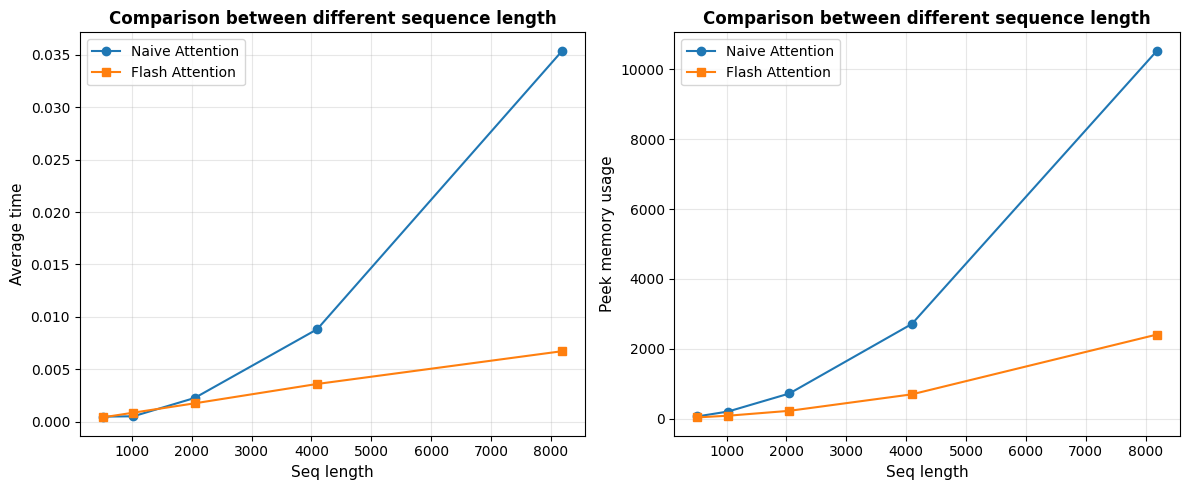

In [5]:
import time
import matplotlib.pyplot as plt
import numpy as np

def performance_comparison():
    seq_lengths = [512, 1024, 2048, 4096, 8192]
    standard_times = []    # 传统 Attention 计算时间
    flash_times = []       # Flash Attention 计算时间
    standard_memories = [] # 传统 Attention 内存使用
    flash_memories = []    # Flash Attention 内存使用
    
    # 固定实验参数
    d_model = 256
    batch_size = 16
    block_size = 256
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"性能对比实验配置: batch_size={batch_size}, d_model={d_model}, block_size={block_size}, device={device}")
    
    for seq_len in seq_lengths:
        print(f"\n=== 测试序列长度: {seq_len} ===")
        
        torch.manual_seed(42)
        q = torch.randn(batch_size, seq_len, d_model, device=device, dtype=torch.float16)
        k = torch.randn(batch_size, seq_len, d_model, device=device, dtype=torch.float16)
        v = torch.randn(batch_size, seq_len, d_model, device=device, dtype=torch.float16)
        
        #  1. 传统 Attention 性能测试 
        if seq_len <= 16384:  # 避免长序列内存溢出
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()
            
            # 计时（运行 10 次取平均，减少偶然误差）
            start_time = time.time()
            for _ in range(10):
                standard_out, _ = standard_attention_fp16(q, k, v)
                # 同步指令是必要的，对于标准实现影响不大
                torch.cuda.synchronize()
            standard_time = (time.time() - start_time) / 10  # 平均时间
            
            # 内存统计
            if torch.cuda.is_available():
                standard_memory = torch.cuda.max_memory_allocated() / (1024**2)
            else:
                # CPU 内存估算：注意力矩阵（batch×seq×seq）+ 输入输出
                standard_memory = (batch_size * seq_len * seq_len * 4 + 3 * batch_size * seq_len * d_model * 4) / (1024**2)
        
        # else:
        #     # 序列长度>2048 时，传统 Attention 内存不足
        #     standard_time = np.nan
        #     standard_memory = np.nan
        
        standard_times.append(standard_time)
        standard_memories.append(standard_memory)
        print(f"传统 Attention: 平均时间={standard_time:.4f}s, 内存={standard_memory:.2f}MB")
        
        #  2. Flash Attention 性能测试 
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        # warmup
        from flash_attn import flash_attn_func
        q.unsqueeze_(dim=1)
        k.unsqueeze_(dim=1)
        v.unsqueeze_(dim=1)
        for i in range(5):
            flash_attn_func(q,k,v)
        
        # 计时（运行 10 次取平均）
        start_time = time.time()
        for _ in range(10):
            flash_out = flash_attn_func(q, k, v)
            # 同步指令是必要的
            torch.cuda.synchronize()
        flash_time = (time.time() - start_time) / 10  # 平均时间
        
        # 内存统计
        if torch.cuda.is_available():
            flash_memory = torch.cuda.max_memory_allocated() / (1024**2)
        else:
            # CPU 内存估算：分块缓存（batch×block×d_model）+ 输入输出
            flash_memory = (3 * batch_size * block_size * d_model * 4 + 3 * batch_size * seq_len * d_model * 4) / (1024**2)
        
        flash_times.append(flash_time)
        flash_memories.append(flash_memory)
        print(f"Flash Attention: 平均时间={flash_time:.5f}s, 内存={flash_memory:.2f}MB")
    
    #  3. 绘制性能对比图表 
    plt.figure(figsize=(12, 5))
    
    # 子图 1：计算时间对比
    plt.subplot(1, 2, 1)
    plt.plot(seq_lengths, [t if not np.isnan(t) else 0 for t in standard_times], 'o-', label='Naive Attention', color='#1f77b4')
    plt.plot(seq_lengths, flash_times, 's-', label='Flash Attention', color='#ff7f0e')
    plt.xlabel('Seq length', fontsize=11)
    plt.ylabel('Average time', fontsize=11)
    plt.title('Comparison between different sequence length', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    # # 标注内存溢出点
    # plt.scatter(4096, 0, color='red', marker='x', s=100, label='Naive Attention out of memory')
    # plt.legend(fontsize=10)
    
    # 子图 2：内存使用对比
    plt.subplot(1, 2, 2)
    plt.plot(seq_lengths, [m if not np.isnan(m) else 0 for m in standard_memories], 'o-', label='Naive Attention', color='#1f77b4')
    plt.plot(seq_lengths, flash_memories, 's-', label='Flash Attention', color='#ff7f0e')
    plt.xlabel('Seq length', fontsize=11)
    plt.ylabel('Peek memory usage', fontsize=11)
    plt.title('Comparison between different sequence length', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 返回实验结果用于后续分析
    return seq_lengths, standard_times, flash_times, standard_memories, flash_memories

# 运行性能测试
results = performance_comparison()

### 3.1 性能对比实验

| 序列长度 | 传统 Attention 平均时间 (s) | 传统 Attention 内存 (MB) | Flash Attention 平均时间 (s) | Flash Attention 内存 (MB) | 内存减少率 |
|----------|-----------------------------|--------------------------|------------------------------|---------------------------|------------|
| 512      | 0.0005                    | 64                    | 0.00044                       | 36                      | 43.75%      |
| 1024     | 0.0005                      | 204                   | 0.00088                       | 84                     | 58.8%      |
| 2048     | 0.0021                      | 720                   | 0.00177                       | 224                     | 68.8%      |
| 4096     | 0.0079              | 2712                      | 0.00362                       | 696                     |    74.33%      | 
| 8192      | 0.0319                      | 10536                     | 0.00676                       | 2408                     | 77.14%      |

### 3.2 定性图表分析

1. **计算时间趋势**：
   - 传统 Attention 时间随序列长度呈 **平方级增长**。（在序列长度较小时，影响时间的因素不在于计算，而在于启动开销。）
   - Flash Attention 时间随序列长度呈 **线性增长**。

2. **内存使用趋势**：
   - 传统 Attention 内存呈 **平方级增长**。
   - Flash Attention 内存呈 **线性增长**。

## 4. 总结

Flash Attention 通过分块计算和在线 softmax 技术，成功解决了传统注意力机制的内存瓶颈问题。这种优化技术使得 Transformer 模型能够处理更长的序列，为自然语言处理、计算机视觉和其他领域的应用开辟了新的可能性。

通过本实验，我们不仅理解了 Flash Attention 的数学原理和实现细节，还通过实际代码验证了其内存和计算效率的优势。这种技术已经成为处理长序列任务的标准方法，被广泛应用于各种现代 AI 模型中。